Header is already present.


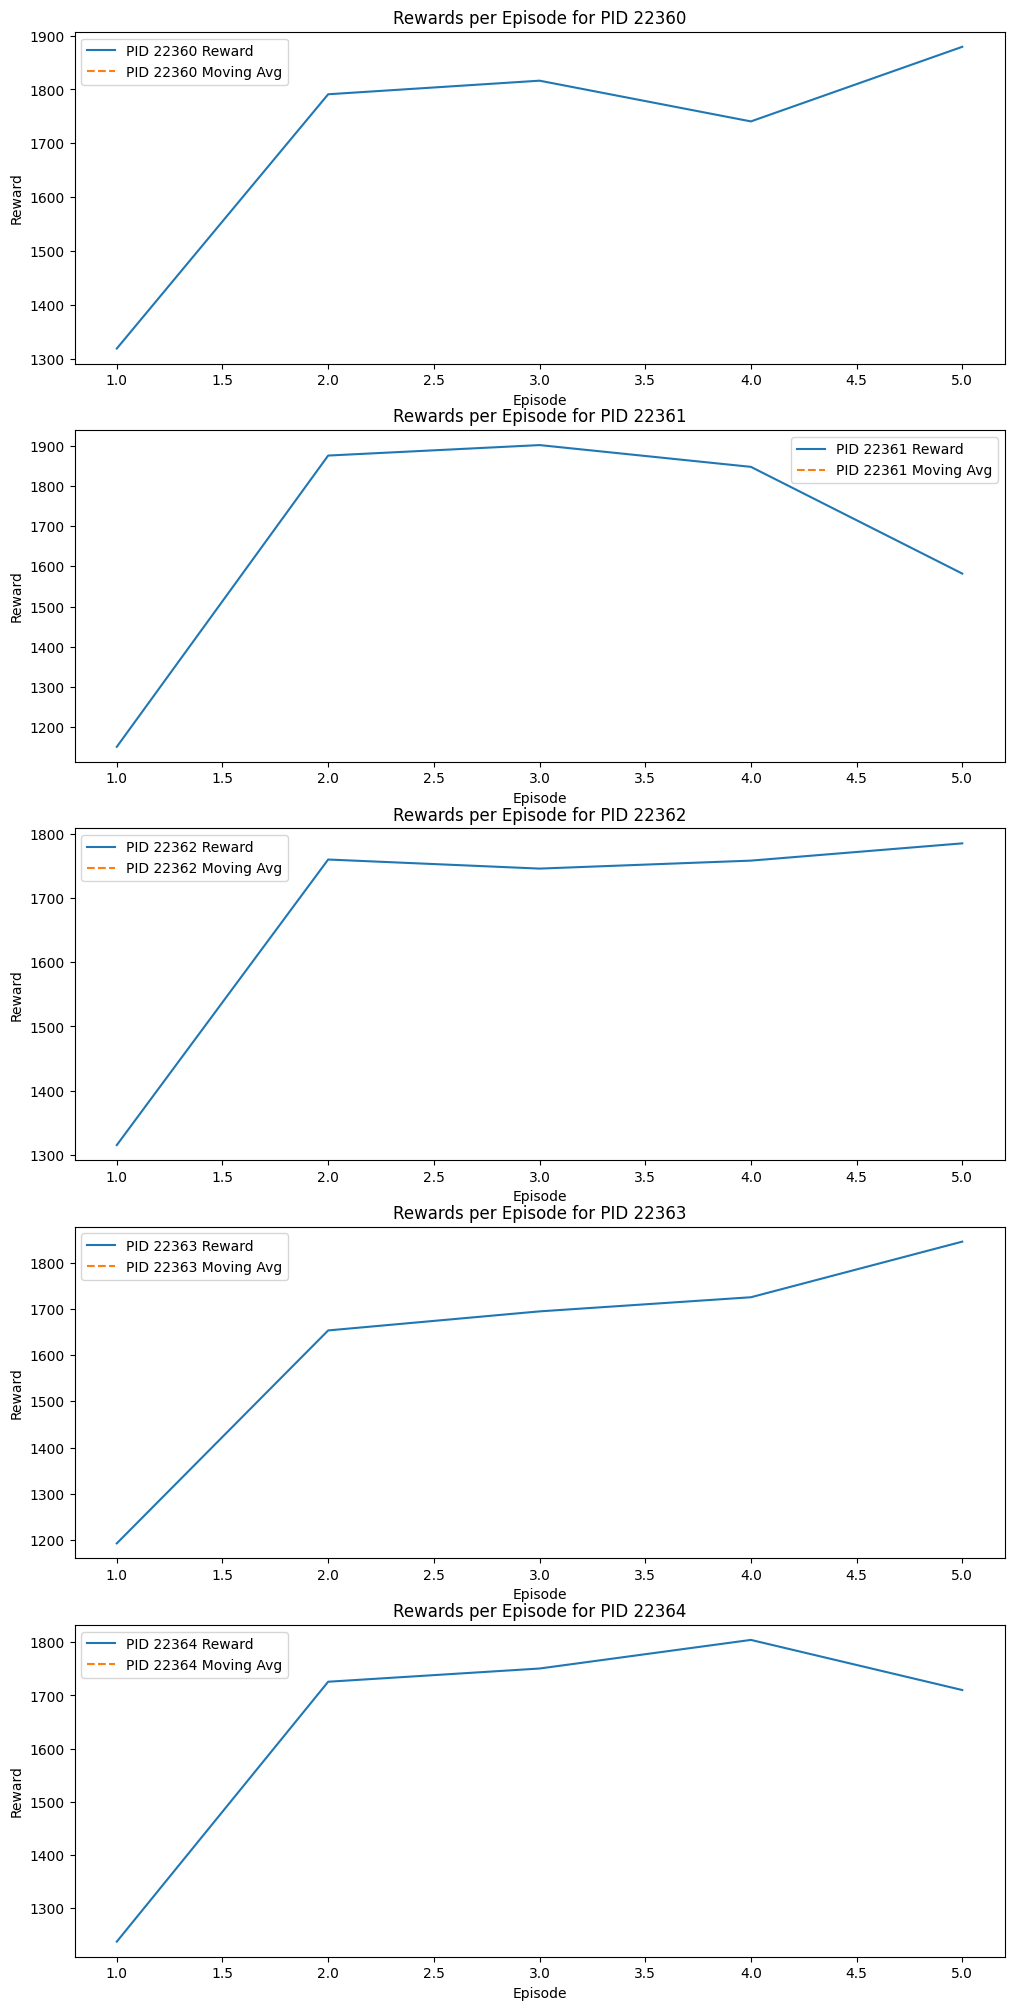

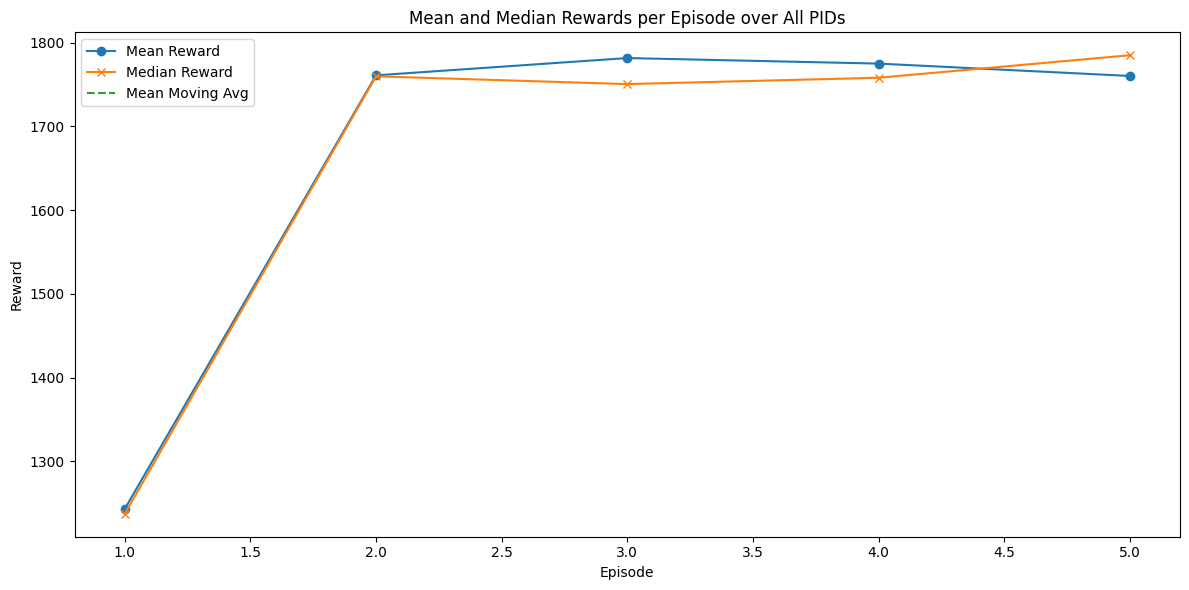

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

def calculate_moving_average(data, window_size=10):
    return data.rolling(window=window_size).mean()

def add_header_if_missing(file_path, header):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        first_row = next(reader)
        
        # Check if the first row is the header
        if first_row != header:
            # Read the rest of the file
            rest_of_file = list(reader)
            
            # Write the header and the rest of the file back
            with open(file_path, 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(header)
                writer.writerow(first_row)  # Write the first row as data
                writer.writerows(rest_of_file)
        else:
            print("Header is already present.")

def analyze_rewards(csv_file):
    # Define the expected header
    header = ['PID', 'Episode', 'Reward']
    
    # Verify if the file has a header, if not, add it
    add_header_if_missing(csv_file, header)
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Group by PID and calculate mean rewards for each PID
    grouped_by_pid = df.groupby(['PID', 'Episode'])['Reward'].mean().reset_index()
    
    # Group by Episode and calculate mean and median rewards over all PIDs
    grouped_by_episode = df.groupby('Episode')['Reward'].agg(['mean', 'median']).reset_index()
    
    # Calculate moving averages
    grouped_by_pid['Moving_Avg'] = grouped_by_pid.groupby('PID')['Reward'].transform(lambda x: calculate_moving_average(x, window_size=10))
    grouped_by_episode['Moving_Avg'] = calculate_moving_average(grouped_by_episode['mean'], window_size=10)
    
    # Plot the results
    num_pids = grouped_by_pid['PID'].nunique()
    fig, axes = plt.subplots(nrows=num_pids, ncols=1, figsize=(12, 5 * num_pids))
    
    if num_pids == 1:
        axes = [axes]
    
    for i, pid in enumerate(grouped_by_pid['PID'].unique()):
        pid_data = grouped_by_pid[grouped_by_pid['PID'] == pid]
        
        axes[i].plot(pid_data['Episode'], pid_data['Reward'], label=f'PID {pid} Reward')
        axes[i].plot(pid_data['Episode'], pid_data['Moving_Avg'], label=f'PID {pid} Moving Avg', linestyle='--')
        
        axes[i].set_title(f'Rewards per Episode for PID {pid}')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Reward')
        axes[i].legend()
    
    # Plot mean and median rewards over all PIDs in a separate figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(grouped_by_episode['Episode'], grouped_by_episode['mean'], label='Mean Reward', marker='o')
    ax.plot(grouped_by_episode['Episode'], grouped_by_episode['median'], label='Median Reward', marker='x')
    ax.plot(grouped_by_episode['Episode'], grouped_by_episode['Moving_Avg'], label='Mean Moving Avg', linestyle='--')
    
    ax.set_title('Mean and Median Rewards per Episode over All PIDs')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    analyze_rewards('DQN-runs/run_27_12_04_53_1000/data/episode_rewards.csv')